# Derive models of spacecraft with star tracker

Do all imports.

In [1]:
import sympy as sym
import numpy as np
from scipy import linalg
np.set_printoptions(precision=5, suppress=True)
from sympy import *
init_printing(use_unicode=True)
import random

# Standard modules
import time
import matplotlib.pyplot as plt

# My own script (an interface to the simulator)
import ae353_spacecraft

pybullet build time: Jan 28 2022 20:18:15


## Dynamic model

Specify the physical parameters:

In [2]:
# Mass and MOI of base
mb = 6.
Jxb = 10.
Jyb = 10.
Jzb = 16.

# Mass and MOI of each wheel
mw = 1.
Jxw = 0.075
Jyw = 0.075
Jzw = 0.125
lw = 1.1

Derive the equations of motion:

In [3]:
# Define yaw, pitch, roll yaw angles
psi, theta, phi = sym.symbols('psi, theta, phi')

# Define angular velocities
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# Define torques
tau_1, tau_2, tau_3, tau_4 = sym.symbols('tau_1, tau_2, tau_3, tau_4')

# Compute resultant torques
lt = sym.nsimplify(lw) * sym.sqrt(2) / 2
T1 = - tau_1 * sym.Matrix([[lt], [0], [lt]])
T2 = - tau_2 * sym.Matrix([[-lt], [0], [lt]])
T3 = - tau_3 * sym.Matrix([[0], [lt], [lt]])
T4 = - tau_4 * sym.Matrix([[0], [-lt], [lt]])
T = T1 + T2 + T3 + T4

# Define MOI of spacecraft and wheels together
Jx = sym.nsimplify(Jxb + 4 * mw * lw**2)
Jy = sym.nsimplify(Jyb + 4 * mw * lw**2)
Jz = sym.nsimplify(Jzb + 4 * mw * lw**2)

# Define rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])

# Define the transformation from angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# Define euler's equations
euler = sym.Matrix([[(1 / Jx) * (T[0] + (Jy - Jz) * w_y * w_z)],
                   [(1 / Jy) * (T[1] + (Jz - Jx) * w_z * w_x)],
                   [(1 / Jz) * (T[2] + (Jx - Jy) * w_x * w_y)]])

# Define equations of motion
f = sym.simplify(sym.Matrix.vstack(M * sym.Matrix([[w_x], [w_y], [w_z]]), euler), full=True)

The equations of motion have this form:

$$\begin{bmatrix} \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \\ \dot{w_x} \\ \dot{w_y} \\ \dot{w_z} \end{bmatrix} = f\left(\psi, \theta, \phi, w_x, w_y, w_z, \tau_1, \tau_2, \tau_3, \tau_4\right)$$

Here is the function $f$:

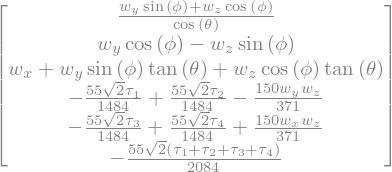

In [4]:
f

In [5]:
#equilibrium points
psi_eq   = 0.   # yaw
theta_eq = 0.   # pitch
phi_eq   = 0.   # roll
w_x_eq   = 0.
w_y_eq   = 0.
w_z_eq   = 0.

tau_1_eq = 0.   # front wheel torque
tau_2_eq = 0.   # back wheel torque
tau_3_eq = 0.   # left wheel torque
tau_4_eq = 0.   # right wheel torque

# verify validity of equilibrium points
f_num = sym.lambdify((phi, theta, psi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4), f)
if not np.allclose(f_num(phi_eq, theta_eq, psi_eq, w_x_eq, w_y_eq, w_z_eq, tau_1_eq, tau_2_eq, tau_3_eq, tau_4_eq), 0.):
    raise Exception('equilibrium point is invalid')

In [6]:
A_num = sym.lambdify((psi, theta, phi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4),
                     f.jacobian([psi, theta, phi, w_x, w_y, w_z]))
A = A_num(psi_eq, theta_eq, phi_eq, w_x_eq, w_y_eq, w_z_eq, tau_1_eq, tau_2_eq, tau_3_eq, tau_4_eq)
print('A (state matrix): \n', A)

B_num = sym.lambdify((psi, theta, phi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4),
                     f.jacobian([tau_1, tau_2, tau_3, tau_4]))
B = B_num(psi_eq, theta_eq, phi_eq, w_x_eq, w_y_eq, w_z_eq, tau_1_eq, tau_2_eq, tau_3_eq, tau_4_eq)
print('\n B (input matrix): \n', B)

A (state matrix): 
 [[ 0.  0.  0.  0.  0.  1.]
 [ 0.  0. -0.  0.  1. -0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]

 B (input matrix): 
 [[ 0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [-0.05241  0.05241  0.       0.     ]
 [ 0.       0.      -0.05241  0.05241]
 [-0.03732 -0.03732 -0.03732 -0.03732]]


### Controllability ###

In [7]:
# defining W = [B, AB, (A^2)B, ... (A^n-1)B]
W_c = B
for i in range(1, A.shape[0]):
    col_c = np.linalg.matrix_power(A, i) @ B
    W_c = np.block([W_c, col_c])

# compare the rank of W to the size of A;
if not np.allclose(np.linalg.matrix_rank(W_c), A.shape[0]):
    raise Exception('System is not controllable (not full rank)')

### LQR ###

In [8]:
# define lqr function
def lqr(a, b, q, r):
    P = linalg.solve_continuous_are(a, b, q, r)
    return linalg.inv(r) @ b.T @ P

In [9]:
# psi, theta, phi, wx, wy, wz
Qc = np.diag([100000.,100000.,100000.,10000.,10000.,10000.]) 

# torques
Rc = np.diag([1000.,1000.,1000.,1000.])

K = lqr(A,B,Qc,Rc)

# verify all eigvals have negative real parts
F = A - B @ K
s = linalg.eigvals(F)
if not (((s.real < 0).all())):
    raise Exception('eigval real parts are not all negative ')

## Sensor model

Symbolic variables for right ascension $\alpha$ and declination $\delta$ of each star:

In [10]:
alpha, delta = sym.symbols('alpha, delta')

Specify the physical parameters:

In [11]:
# Scope radius
r = 0.8 / 2.1

Derive the sensor model:

In [12]:
# Position of star in space frame
p_star_in_space = sym.Matrix([[sym.cos(alpha) * sym.cos(delta)],
                              [sym.sin(alpha) * sym.cos(delta)],
                              [sym.sin(delta)]])

# Orientation of body frame in space frame
R_body_in_space = Rz * Ry * Rx

# Position of star in body frame (assuming origin of body and space frames are the same)
p_star_in_body = R_body_in_space.T * p_star_in_space

# Position of star in image frame
p_star_in_image = (1 / sym.nsimplify(r)) * sym.Matrix([[p_star_in_body[1] / p_star_in_body[0]],
                                                       [p_star_in_body[2] / p_star_in_body[0]]])

# Sensor model for each star
g = sym.simplify(p_star_in_image, full=True)

The sensor model has this form for each star:

$$\zeta = g(\psi, \theta, \phi, \alpha, \delta)$$

Here is the function $g$:

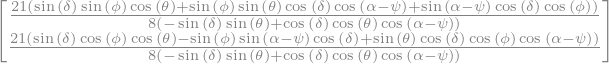

In [13]:
g

### Observer ###

In [14]:
# star ascension and declination from simulator

alpha1 = -.1
delta1 = -.15

alpha2 = 0.
delta2 = -.15

alpha3 = .1
delta3 = -.15

alpha4 = 0.
delta4 =0.

alpha5 = -.1
delta5 = .15

alpha6 = 0.
delta6 = .15

alpha7 = .1
delta7 = .15

In [15]:

G = sym.Matrix([[g.subs([(alpha, alpha1), (delta, delta1)])],
                [g.subs([(alpha, alpha2), (delta, delta2)])],
                [g.subs([(alpha, alpha3), (delta, delta3)])],
                [g.subs([(alpha, alpha4), (delta, delta4)])],
                [g.subs([(alpha, alpha5), (delta, delta5)])],
                [g.subs([(alpha, alpha6), (delta, delta6)])],
                [g.subs([(alpha, alpha7), (delta, delta7)])]])

G_num = sym.lambdify((phi, theta, psi), G)
Ge = G_num(phi_eq, theta_eq, psi_eq)

# sensor equilibrium should not be zero
print('Ge: \n', Ge)

Ge: 
 [[-0.26338]
 [-0.39872]
 [ 0.     ]
 [-0.39673]
 [ 0.26338]
 [-0.39872]
 [ 0.     ]
 [ 0.     ]
 [-0.26338]
 [ 0.39872]
 [ 0.     ]
 [ 0.39673]
 [ 0.26338]
 [ 0.39872]]


In [16]:
C_num = sym.lambdify((phi, theta, psi), G.jacobian([phi, theta, psi, w_x, w_y, w_z]))
C = C_num(phi_eq, theta_eq, psi_eq)
print('C: \n', C)

C: 
 [[-0.39872  0.04001 -2.65143  0.       0.       0.     ]
 [ 0.26338  2.68556 -0.04001  0.       0.       0.     ]
 [-0.39673  0.      -2.625    0.       0.       0.     ]
 [ 0.       2.68496  0.       0.       0.       0.     ]
 [-0.39872 -0.04001 -2.65143  0.       0.       0.     ]
 [-0.26338  2.68556  0.04001  0.       0.       0.     ]
 [ 0.       0.      -2.625    0.       0.       0.     ]
 [ 0.       2.625    0.       0.       0.       0.     ]
 [ 0.39872 -0.04001 -2.65143  0.       0.       0.     ]
 [ 0.26338  2.68556  0.04001  0.       0.       0.     ]
 [ 0.39673  0.      -2.625    0.       0.       0.     ]
 [ 0.       2.68496  0.       0.       0.       0.     ]
 [ 0.39872  0.04001 -2.65143  0.       0.       0.     ]
 [-0.26338  2.68556 -0.04001  0.       0.       0.     ]]


In [17]:
W_o = C.transpose()
for i in range(1, A.shape[0]):
    col_o = np.linalg.matrix_power(A.transpose(), i) @ C.transpose()
    W_o = np.block([W_o, col_o])

# compare the rank of W to the size of A;
if not np.allclose(np.linalg.matrix_rank(W_o), A.shape[0]):
    raise Exception('System is not observable (not full rank)')

In [18]:
Qo = np.diag([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Ro = np.eye(6)

Roi = linalg.inv(Ro)
Qoi = linalg.inv(Qo)

Lt = lqr(A.T, C.T, Roi, Qoi)
L = Lt.T
print('L: \n', L)

L: 
 [[-0.60253  0.39801 -0.59952  0.      -0.60253 -0.39801  0.       0.
   0.60253  0.39801  0.59952  0.       0.60253 -0.39801]
 [ 0.0064   0.42939  0.       0.42929 -0.0064   0.42939  0.       0.4197
  -0.0064   0.42939  0.       0.42929  0.0064   0.42939]
 [-0.43047 -0.0065  -0.42618 -0.      -0.43047  0.0065  -0.42618 -0.
  -0.43047  0.0065  -0.42618 -0.      -0.43047 -0.0065 ]
 [-0.37956 -0.00573 -0.37577 -0.      -0.37956  0.00573 -0.37577 -0.
  -0.37956  0.00573 -0.37577 -0.      -0.37956 -0.00573]
 [ 0.00565  0.37917  0.       0.37909 -0.00565  0.37917 -0.       0.37062
  -0.00565  0.37917 -0.       0.37909  0.00565  0.37917]
 [-0.35978  0.23766 -0.35798  0.      -0.35978 -0.23766 -0.       0.
   0.35978  0.23766  0.35798  0.       0.35978 -0.23766]]


# Simulator #

In [19]:
# # constructor, only run once
simulator = ae353_spacecraft.Simulator(
    display=False,
    seed=5,
)

$$\hat{\dot{x}} = A\hat{x} + Bu - L(C\hat{x} - y)$$

In [20]:
class Controller:
    def __init__(self):
        pass
    
    def reset(self):
        pass
    
    def run(self, t, star_meas):
        """
        star_meas is a 1d array of length 14 - the image coordinates
        y_i and z_i of the i'th star (for i = 0, ..., 6) are at index
        2*i and 2*i+1 of this array, respectively
        """
        
        # FIXME: replace the following lines
        xhat = np.zeros((6,1))
        dt = 0.01
        
    
        u = -K @ xhat
        xhat_old = xhat
        for i in range(xhat.shape[0]):
            if np.isnan(xhat[i,0]):
                xhat[i,0] = xhat_old[i,0]
        out = np.array([star_meas])

        xhat += dt * (A @ xhat + B @ u - L @ (C @ xhat - (out.T - Ge)))

        u = -K @ xhat
        
        front_torque = u[0,0]
        back_torque = u[1,0]
        left_torque = u[2,0]
        right_torque = u[3,0]
        
        
        return front_torque, back_torque, left_torque, right_torque

In [21]:
controller = Controller()

In [22]:
simulator.reset(
    orientation={
        'yaw': 0.,
        'pitch': 0.,
        'roll': 0.,
    },
    angular_velocity={
        'x': 0.,
        'y': 0.,
        'z': 0.,
    },
    scope_noise=0.1,
)

In [23]:
controller.reset()

In [24]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=10.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
    print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
)

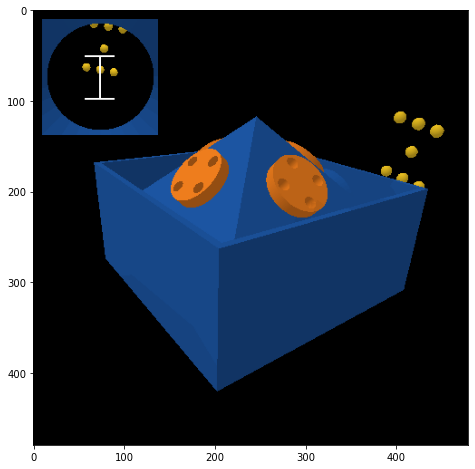

In [25]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

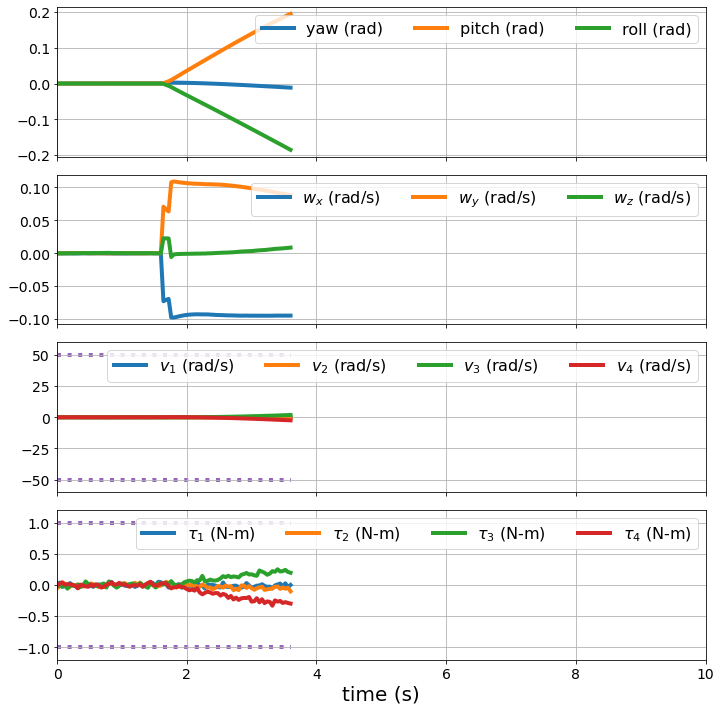

In [26]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_ori, ax_vel, ax_rwvel, ax_rwtau) = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# Plot yaw, pitch, roll angles
ax_ori.plot(data['t'], data['yaw'], label='yaw (rad)', linewidth=4)
ax_ori.plot(data['t'], data['pitch'], label='pitch (rad)', linewidth=4)
ax_ori.plot(data['t'], data['roll'], label='roll (rad)', linewidth=4)
ax_ori.grid()
ax_ori.legend(fontsize=16, ncol=3, loc='upper right')
ax_ori.tick_params(labelsize=14)

# Plot x, y, z components of angular velocity
ax_vel.plot(data['t'], data['w_x'], label=r'$w_x$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_y'], label=r'$w_y$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_z'], label=r'$w_z$ (rad/s)', linewidth=4)
ax_vel.grid()
ax_vel.legend(fontsize=16, ncol=3, loc='upper right')
ax_vel.tick_params(labelsize=14)

# Plot angular velocity of each reaction wheel
ax_rwvel.plot(data['t'], data['front_velocity'], label=r'$v_1$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['back_velocity'], label=r'$v_2$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['left_velocity'], label=r'$v_3$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['right_velocity'], label=r'$v_4$ (rad/s)', linewidth=4)
ax_rwvel.plot(
    data['t'], np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.plot(
    data['t'], -np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.grid()
ax_rwvel.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwvel.tick_params(labelsize=14)
ax_rwvel.set_ylim(-1.2 * simulator.v_max, 1.2 * simulator.v_max)

# Plot torque applied to each reaction wheel
ax_rwtau.plot(data['t'], data['front_torque'], label=r'$\tau_1$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['back_torque'], label=r'$\tau_2$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['left_torque'], label=r'$\tau_3$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['right_torque'], label=r'$\tau_4$ (N-m)', linewidth=4)
ax_rwtau.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.grid()
ax_rwtau.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwtau.tick_params(labelsize=14)


# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_rwtau.set_xlabel('time (s)', fontsize=20)
ax_rwtau.set_xlim([data['t'][0], 10]) #data['t'][-1]]
ax_rwtau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()

In [27]:
n = 200                          # number of sims
times = np.zeros(n)
steps = np.zeros(n)
yaws = np.empty(n)
rolls = np.empty(n)
pitchs = np.empty(n)

for i in range (n):
#     controller = Controller()
    simulator.reset(
        orientation={
            'yaw': 0.,
            'pitch': 0.,
            'roll': 0.,
        },
        angular_velocity={
            'x': 0.,
            'y': 0.,
            'z': 0.,
        },
        scope_noise=0.1,
    )
    controller.reset()
    
    data = simulator.run(
        controller,           
        max_time=50.0,         
        data_filename=None,   
        video_filename=None,  
        print_debug=False,   
    )
    
    # save time data
    times[i] =  data['t'][-1]
    steps[i] = data['t'].size
    
    # calculate root mean square error of instance
    yaws[i] = np.sum(data['yaw']**2) / data['t'].size
    rolls[i] = np.sum(data['roll']**2) / data['t'].size
    pitchs[i] = np.sum(data['pitch']**2) / data['t'].size

In [28]:
np.average(times)

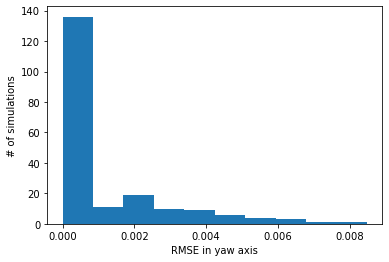

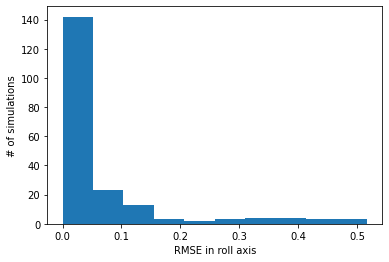

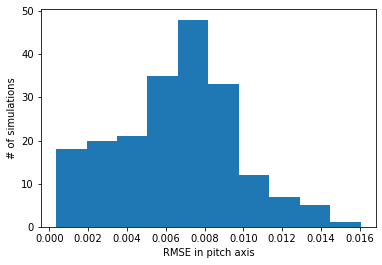

In [29]:
# plot RMSE values

plt.hist(yaws)
plt.xlabel('RMSE in yaw axis')
plt.ylabel('# of simulations')
plt.show()

plt.hist(rolls)
plt.xlabel('RMSE in roll axis')
plt.ylabel('# of simulations')
plt.show()

plt.hist(pitchs)
plt.xlabel('RMSE in pitch axis')
plt.ylabel('# of simulations')
plt.show()

Now, we perturb the initial angular velocities.

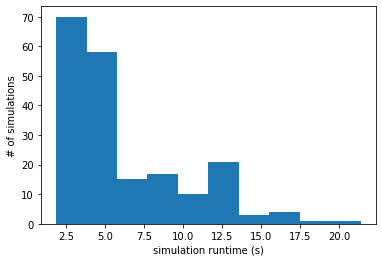

In [30]:
n = 200                          # number of sims
times = np.zeros(n)

for i in range (n):
#     controller = Controller()
    simulator.reset(
        orientation={
            'yaw': 0.,
            'pitch': 0.,
            'roll': 0.,
        },
        angular_velocity={
            'x': .01,
            'y': .01,
            'z': .01,
        },
        scope_noise=0.1,
    )
    controller.reset()
    
    data = simulator.run(
        controller,           # <-- required (an instance of your Controller class)
        max_time=50.0,         # <-- optional (how long you want to run the simulation in seconds)
        data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
        video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
        print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
    )

    times[i] =  data['t'][-1]
    
plt.hist(times)
plt.xlabel('simulation runtime (s)')
plt.ylabel('# of simulations')
plt.show()